In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from dataclasses import dataclass


In [10]:
# Define parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # Resize images to 224x224 for compatibility with many models
DATA_DIR = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"  # Kaggle dataset path
NUM_CLASSES = 4  # Update this to match the number of your categories


In [11]:
# Create training, validation, and test datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,  # Use 20% for validation and 80% for training + test
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Further split the validation dataset to create a test dataset
# This will create an 80-10-10 split (train-validation-test)
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)


Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


In [12]:
# Function to preprocess and one-hot encode labels
def preprocess_and_categorical(image, label):
    image = tf.keras.layers.Rescaling(1./255)(image)  # Normalize images to [0, 1] range
    label = tf.one_hot(label, depth=NUM_CLASSES)  # Convert labels to one-hot encoding
    return image, label


In [13]:
# Apply preprocessing and one-hot encoding to the datasets
train_dataset = train_dataset.map(preprocess_and_categorical)
validation_dataset = validation_dataset.map(preprocess_and_categorical)
test_dataset = test_dataset.map(preprocess_and_categorical)


In [14]:
# Check the shapes of your datasets
for images, labels in train_dataset.take(1):
    print(f'Train images shape: {images.shape}')
    print(f'Train labels shape: {labels.shape}')  # Should be (BATCH_SIZE, NUM_CLASSES)

for images, labels in validation_dataset.take(1):
    print(f'Validation images shape: {images.shape}')
    print(f'Validation labels shape: {labels.shape}')  # Should be (BATCH_SIZE, NUM_CLASSES)

for images, labels in test_dataset.take(1):
    print(f'Test images shape: {images.shape}')
    print(f'Test labels shape: {labels.shape}')  # Should be (BATCH_SIZE, NUM_CLASSES)


Train images shape: (32, 224, 224, 3)
Train labels shape: (32, 4)
Validation images shape: (32, 224, 224, 3)
Validation labels shape: (32, 4)
Test images shape: (32, 224, 224, 3)
Test labels shape: (32, 4)


In [15]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 4  # Adjust if necessary
    IMG_HEIGHT: int = 224
    IMG_WIDTH: int = 224
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS: int = 20
    BATCH_SIZE: int = BATCH_SIZE
    LEARNING_RATE: float = 0.0001


In [16]:
# Define the transfer learning model with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all but the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
# Compile the model
optimizer = Adam(learning_rate=TrainingConfig.LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [19]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=TrainingConfig.EPOCHS,
    callbacks=[lr_scheduler],
    verbose=1
)


Epoch 1/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.6332 - loss: 0.9059 - val_accuracy: 0.8011 - val_loss: 0.4917 - learning_rate: 1.0000e-04
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.9051 - loss: 0.2475 - val_accuracy: 0.8696 - val_loss: 0.3474 - learning_rate: 1.0000e-04
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.9606 - loss: 0.1083 - val_accuracy: 0.8699 - val_loss: 0.4234 - learning_rate: 1.0000e-04
Epoch 4/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.9737 - loss: 0.0702 - val_accuracy: 0.9401 - val_loss: 0.1899 - learning_rate: 1.0000e-04
Epoch 5/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.9816 - loss: 0.0523 - val_accuracy: 0.8587 - val_loss: 0.5793 - learning_rate: 1.0000e-04
Epoch 6/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 72s 84ms/step - accuracy: 0.9857 - loss: 0.0398 - val_accuracy: 0.9689 - val_loss: 0.1043 - learning_rate: 1.0000e-04
Epoch 7/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/s

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7cf945f4f1c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt



In [20]:
# Save the entire model
model.save("alzheimer_model.h5")


In [21]:
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model("alzheimer_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


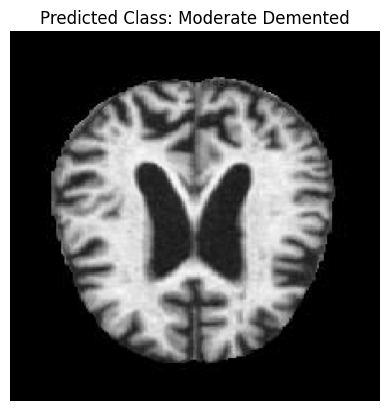

In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non-Demented', 'Very Mild Demented']  # Adjust to match your class order

# Path to the new image
image_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/ModerateDemented/30 (2).jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize as done during training

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class name using the index
predicted_class_name = class_names[predicted_class]

# Display the image and predicted class name
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()
